# Combining Predictive Techniques

## Data Given

* StoreSalesData.csv - This file contains sales by product category for all existing stores for 2012, 2013, and 2014.
* StoreInformation.csv - This file contains location data for each of the stores.
* StoreDemographicData.csv - This file contains demographic data for the areas surrounding each of the existing stores and locations for new stores.

Load Package

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics import tsaplots

import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [11, 7]

Load Data

In [2]:
# Load Stores Sales
stores_sales_data = pd.read_csv('storesalesdata.csv')
# Bad Data: There no date 29-Feb-2014, Drod the data
# stores_sales_data = stores_sales_data.query('Date != "2014 02 29"')
# Convert Date varible to daterime object
# stores_sales_data = stores_sales_data.assign(Date = pd.to_datetime(stores_sales_data['Date']))

stores_sales_data.head(3)

,Store,Day,Month,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
0,S0001,1,3,2012,23401.06,5567.90,3930.28,5223.61,4542.28,238.58,2608.78,1651.77,4304.79
1,S0001,2,3,2012,32442.93,8009.52,4712.31,6174.72,9503.45,245.29,2692.72,2688.89,4467.51
2,S0001,3,3,2012,40433.61,9759.20,5969.03,8010.67,12793.92,282.12,3493.85,2929.85,5721.60


In [3]:
# Load Store Information
store_information_data = pd.read_csv('storeinformation.csv')
store_information_data.head(3)

,Store,Address,City,State,Zip,Type
0,S0001,1000 W El Norte Pkwy,Escondido,CA,92027,Existing
1,S0002,12419 Woodside Ave,Lakeside,CA,92040,Existing
2,S0003,1342 N Alvarado St,Los Angeles,CA,90026,Existing


In [4]:
# Load Store Demographic Data
store_demographic_data = pd.read_csv('storedemographicdata.csv')
store_demographic_data.head(3)

,Store,Age0to9,Age10to17,Age18to24,Age25to29,Age30to39,Age40to49,Age50to64,Age65Plus,EdLTHS,...,PopPacIsl,PopWhite,HVal0to100K,HVal100Kto200K,HVal200Kto300K,HVal300Kto400K,HVal400Kto500K,HVal500Kto750K,HVal750KPlus,PopDens
0,S0001,0.138163,0.111414,0.113228,0.081671,0.134924,0.128832,0.160429,0.131359,0.241935,...,0.002669,0.454295,0.073853,0.115967,0.223511,0.301880,0.180786,0.097168,0.006836,4260.943672
1,S0002,0.138954,0.112723,0.100572,0.074832,0.121080,0.146961,0.195456,0.109422,0.125224,...,0.002879,0.729696,0.124956,0.127915,0.206578,0.223808,0.174730,0.129133,0.012879,3061.060073
2,S0003,0.108582,0.091262,0.113486,0.111415,0.182909,0.144938,0.150248,0.097170,0.321860,...,0.000802,0.182080,0.024665,0.065257,0.114870,0.150106,0.155462,0.251445,0.238196,13740.923328


## Task 1: Store Format (segments) for Existing Stores

To remedy the product surplus and shortages, the company wants to introduce different store formats. Each store format will have a different product selection in order to better match local demand. The actual building sizes will not change, just the product selection and internal layouts.

* Determine the optimal number of store formats based on sales data.
    - Sum sales data by StoreID and Year
    - Use percentage sales per category per store for clustering (category sales as a percentage of total store sales).
    - Use only 2015 sales data.
    - Use a K-means clustering model.

* Segment the 85 current stores into the different store formats.
* Use the StoreSalesData.csv and StoreInformation.csv files.

## Task 1 Submission
1. What is the optimal number of store formats? How did you arrive at that number?
2. How many stores fall into each store format?
3. Based on the results of the clustering model, what is one way that the clusters differ from one another?
4. Please provide a map created in Tableau that shows the location of the existing stores, uses color to show cluster, and size to show total sales. Make sure to include a legend! Feel free to simply copy and paste the map into the submission template.

In [5]:
# Aggregate sum of sales by Store and Year
filtered_columns = ['Dry_Grocery', 'Dairy', 'Frozen_Food', 'Meat', 'Produce', 'Floral', 'Deli', 'Bakery', 'General_Merchandise']
filtered_stores_data =  stores_sales_data.groupby(['Store', 'Year'], as_index=False)[filtered_columns].sum()
# Add Store Total Sales per year
filtered_stores_data = filtered_stores_data.assign(Total_Sales = filtered_stores_data[filtered_columns].sum(axis=1))
# Calculate percentage sales per category per store
filtered_stores_data[filtered_columns] = filtered_stores_data[filtered_columns].div(filtered_stores_data['Total_Sales'], axis=0)

# Filter 2015 data
filtered_stores_sales_2015_data = filtered_stores_data.query('Year == 2015')

print('\nFiltered and Aggregated 2015 Store Data')
filtered_stores_sales_2015_data.head()



Filtered and Aggregated 2015 Store Data


,Store,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise,Total_Sales
3,S0001,2015,0.461347,0.103084,0.077199,0.107677,0.097171,0.006769,0.043550,0.035544,0.067658,23508945.82
7,S0002,2015,0.457528,0.106388,0.078841,0.114903,0.101259,0.007438,0.039792,0.029702,0.064149,17334619.57
11,S0003,2015,0.421349,0.102356,0.069027,0.114713,0.125399,0.009631,0.041761,0.036108,0.079655,30240661.99
15,S0004,2015,0.454560,0.097111,0.080277,0.127728,0.100409,0.006120,0.041785,0.034469,0.057542,27913890.97
19,S0005,2015,0.440169,0.106268,0.086339,0.101863,0.131112,0.008877,0.035389,0.022607,0.067376,27825886.17


In [6]:
# Find best numbers of clusters

# Function to return pandas describe
def cluster_number_test(raw_data, score_metric, number_test, cluster_number_list):
    df_list = []
    scaler = MinMaxScaler().fit_transform(raw_data)

    for i in cluster_number_list:
        score_list = []
        for _ in range(number_test):
            kmeans = KMeans(n_clusters=i)
            kmeans.fit(scaler)
            score = score_metric(raw_data, kmeans.labels_)
            score_list.append(score)

        temp_df = pd.DataFrame(score_list)
        df_list.append(temp_df)

    column_names = [f'Cluster {i}' for i in cluster_number_list]
    _df = pd.concat(df_list, axis=1)
    _df.columns = column_names
    return _df.describe().round(2)


In [7]:
# Finding best number of cluster
raw_data = filtered_stores_sales_2015_data[filtered_columns]
test_count = 100
possible_clusters = range(2,8)


In [8]:
# Run Test
c_h_score = cluster_number_test(raw_data, calinski_harabasz_score, test_count, possible_clusters)
sil_score = cluster_number_test(raw_data, silhouette_score, test_count, possible_clusters)
d_b_score = cluster_number_test(raw_data, davies_bouldin_score, test_count, possible_clusters)

In [9]:
# Metric: Calinski Harabasz Score - Higher the better
print(f'Run Calinski Harabasz Score Test {test_count} times - Higher the better')
print(c_h_score, '\n')
# Metric: Silhoutte Score - Higher the better
print(f'Run Silhoutte Score Test {test_count} times - Higher the better')
print(sil_score, '\n')
# Metric: Davies Bouldin Score - Smaller the better
print(f'Run Davies Bouldin Score Test {test_count} times - Smaller the better')
print(d_b_score)

Run Calinski Harabasz Score Test 100 times - Higher the better
       Cluster 2  Cluster 3  Cluster 4  Cluster 5  Cluster 6  Cluster 7
count     100.00     100.00     100.00     100.00     100.00     100.00
mean       27.31      26.42      24.68      21.41      20.79      19.24
std         0.68       0.38       2.10       1.76       1.47       1.49
min        22.90      24.15      19.53      17.22      16.47      15.87
25%        27.38      26.42      23.54      20.25      20.08      18.20
50%        27.38      26.42      25.67      21.31      20.83      19.23
75%        27.38      26.42      26.11      22.67      21.64      20.15
max        29.75      27.44      26.89      25.23      24.55      22.48 

Run Silhoutte Score Test 100 times - Higher the better
       Cluster 2  Cluster 3  Cluster 4  Cluster 5  Cluster 6  Cluster 7
count     100.00     100.00     100.00     100.00     100.00     100.00
mean        0.21       0.22       0.21       0.19       0.18       0.17
std         0.00

In [10]:
# From above test, what is the best number of cluster?

##### Score Results #####
# Calinski Harabasz Score: 2 Cluster
# Silhoutte Score: 3 Cluster
# Davies Bouldin Score: 3 Cluster

best_number_cluster = 3

In [11]:
# Clusters - number of clusters = 3 
kmeans = KMeans(n_clusters = best_number_cluster)
# scale data
scaled_data = MinMaxScaler().fit_transform(raw_data)
kmeans.fit(scaled_data)
# Add cluser laber to data
filtered_stores_sales_2015_data = filtered_stores_sales_2015_data.assign(Segment = kmeans.labels_)

# check numbers of stores in each Segment
print('\nNumber of stores in Segment')
print(filtered_stores_sales_2015_data['Segment'].value_counts())


Number of stores in Segment
1    32
0    31
2    22
Name: Segment, dtype: int64


In [12]:
# Cluster interpretion: Use centroid
columns_name = ['Dry_Grocery', 'Dairy', 'Frozen_Food', 'Meat', 'Produce', 'Floral', 'Deli', 'Bakery', 'General_Merchandise']
print('\nAvarage distance between store formats')
pd.DataFrame(kmeans.cluster_centers_, columns=columns_name).round(4)


Avarage distance between store formats


,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
0,0.2837,0.4987,0.5593,0.2740,0.6661,0.5085,0.4364,0.4649,0.3206
1,0.5453,0.3369,0.4930,0.4176,0.3738,0.2578,0.6756,0.4299,0.2451
2,0.4628,0.2357,0.4319,0.3354,0.3790,0.3133,0.5079,0.2078,0.7136


In [13]:
# Merge filtered store sale with store
filtered_stores_sales_2015_merged_information_data = filtered_stores_sales_2015_data.merge(store_information_data, how='inner', on='Store')
filtered_stores_sales_2015_merged_information_data.head(2)

,Store,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise,Total_Sales,Segment,Address,City,State,Zip,Type
0,S0001,2015,0.461347,0.103084,0.077199,0.107677,0.097171,0.006769,0.043550,0.035544,0.067658,23508945.82,1,1000 W El Norte Pkwy,Escondido,CA,92027,Existing
1,S0002,2015,0.457528,0.106388,0.078841,0.114903,0.101259,0.007438,0.039792,0.029702,0.064149,17334619.57,1,12419 Woodside Ave,Lakeside,CA,92040,Existing


In [14]:
# TODO
# Plot Clusters
# Scatter Markers Customizing: Size, Color, Shape, Transparency

# filtered_stores_sales_2015_merged_information_data.to_csv('filtered_stores_sales_2015_merged_information_data.csv')
# use above data to plot cluster map in Tableau

## Task 2: Store Format for New Stores

The grocery store chain has 10 new stores opening up at the beginning of the year. The company wants to determine which store format each of the new stores should have. However, we don’t have sales data for these new stores yet, so we’ll have to determine the format using each of the new store’s demographic data.

You’ve been asked to:

* Develop a model that predicts which segment a store falls into based on the demographic and socioeconomic characteristics of the population that resides in the area around each new store.
* Use a 20% validation sample with Random Seed = 3 when creating samples with which to compare the accuracy of the models. Make sure to compare a decision tree, forest, and boosted model.
* Use the model to predict the best store format for each of the 10 new stores.
* Use the StoreDemographicData.csv file, which contains the information for the area around each store.

Note: In a real world scenario, you could use PCA to reduce the number of predictor variables. However, there is no need to do so in this project. You can leave all predictor variables in the model.


## Task 2 Submission
* What methodology did you use to predict the best store format for the new stores? Why did you choose that methodology?
* What are the three most important variables that help explain the relationship between demographic indicators and store formats? Please include a visualization.
* What format do each of the 10 new stores fall into? Please provide a data table.


In [15]:
# 44 variables in demographic store data
store_demographic_columns = ['Age0to9', 'Age10to17', 'Age18to24', 'Age25to29', 'Age30to39', 'Age40to49', 'Age50to64', 'Age65Plus', 'EdLTHS', 'EdHSGrad', 'EdSomeCol', 'EdAssociate', 'EdBachelor', 'EdMaster', 'EdProfSchl', 'EdDoctorate', 'HHSz1Per', 'HHSz2Per', 'HHSz3Per', 'HHSz4Per', 'HHSz5PlusPer', 'HHIncU25K', 'HHInc25Kto50K', 'HHInc50Kto75K',
       'HHInc75Kto100K', 'HHInc100Kto150K', 'HHInc150Kto250K', 'HHInc250KPlus', 'PopAsian', 'PopBlack', 'PopHispanic', 'PopMulti', 'PopNativeAmer', 'PopOther', 'PopPacIsl', 'PopWhite', 'HVal0to100K', 'HVal100Kto200K', 'HVal200Kto300K', 'HVal300Kto400K', 'HVal400Kto500K', 'HVal500Kto750K', 'HVal750KPlus', 'PopDens']

# join demographic data with store information
store_info_columns = ['Store', 'Type']
store_demographic_with_info_data = store_demographic_data.merge(store_information_data[store_info_columns], on='Store')

#  filter existing store
store_demographic_with_info_data_existing = store_demographic_with_info_data.query('Type == "Existing"')
#  filter new store
store_demographic_with_info_data_new = store_demographic_with_info_data.query('Type == "New"')

# merge segment to existing store
store_filtered_columns = ['Store', 'Segment']
_temp_df = filtered_stores_sales_2015_merged_information_data[store_filtered_columns]
store_demographic_with_info_data_existing = store_demographic_with_info_data_existing.merge(_temp_df, on='Store')

# Prepair X and y for training
y = store_demographic_with_info_data_existing['Segment']
X = store_demographic_with_info_data_existing.drop(columns='Segment')
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=3)
# Column Transformer
column_transformer = ColumnTransformer([('numerical', MinMaxScaler(), store_demographic_columns)])
column_transformer.fit(X_train)

ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                 ['Age0to9', 'Age10to17', 'Age18to24',
                                  'Age25to29', 'Age30to39', 'Age40to49',
                                  'Age50to64', 'Age65Plus', 'EdLTHS',
                                  'EdHSGrad', 'EdSomeCol', 'EdAssociate',
                                  'EdBachelor', 'EdMaster', 'EdProfSchl',
                                  'EdDoctorate', 'HHSz1Per', 'HHSz2Per',
                                  'HHSz3Per', 'HHSz4Per', 'HHSz5PlusPer',
                                  'HHIncU25K', 'HHInc25Kto50K', 'HHInc50Kto75K',
                                  'HHInc75Kto100K', 'HHInc100Kto150K',
                                  'HHInc150Kto250K', 'HHInc250KPlus',
                                  'PopAsian', 'PopBlack', ...])])

In [16]:
# Classifier Score on N run test
# Transform Train Data
X_train_transformed = column_transformer.transform(X_train)
# Transform Test Data
X_test_transformed = column_transformer.transform(X_test)

def classifier_test_score(estimator, X_train=X_train_transformed, y_train=y_train, X_test=X_test_transformed, y_test=y_test, cv=100):
    _score_list = []
    for _ in range(cv):
        _cls = estimator().fit(X_train, y_train)
        _score = _cls.score(X_test, y_test)
        _score_list.append(_score)
    return np.array(_score_list)

In [17]:
# Decision Tree Classifier 
decision_tree_result = classifier_test_score(DecisionTreeClassifier)
# Random Forest Classifier
random_forest_result = classifier_test_score(RandomForestClassifier)
# Gradient Boosting Classifier
gradient_boosting = classifier_test_score(GradientBoostingClassifier)

In [18]:
# Model Score
print('Model Accuracy Score in Validation Data')
print(f'Decision Tree Average Accuracy Score in Validation Data: {decision_tree_result.mean().round(2)}')
print(f'Random Forest Average Accuracy Score in Validation Data: {random_forest_result.mean().round(2)}')
print(f'Gradient Boosting Accuracy Average Score in Validation Data: {gradient_boosting.mean().round(2)}')

Model Accuracy Score in Validation Data
Decision Tree Average Accuracy Score in Validation Data: 0.64
Random Forest Average Accuracy Score in Validation Data: 0.78
Gradient Boosting Accuracy Average Score in Validation Data: 0.87


Decision Tree Score in Validation Data: 0.71
Top 3 features: ['HVal750KPlus', 'Age0to9', 'PopBlack']


<AxesSubplot:title={'center':'Decision Tree: Feature Importances'}>

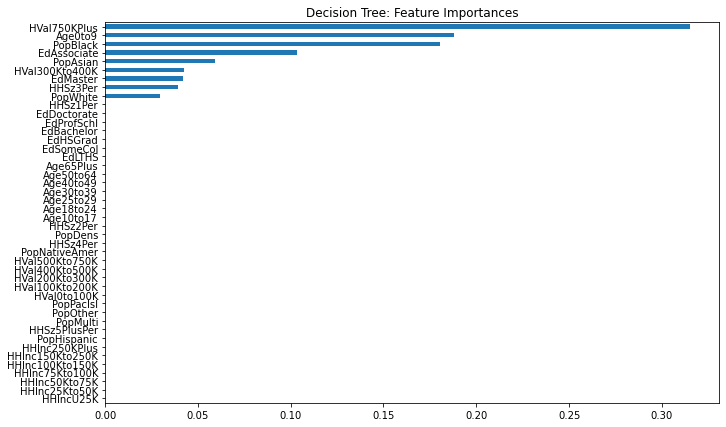

In [19]:
# Plot Feature Importance: Decision Tree
# Score
decision_tree_model = DecisionTreeClassifier().fit(X_train_transformed, y_train)
print(f'Decision Tree Score in Validation Data: {decision_tree_model.score(X_test_transformed, y_test).round(2)}')
# Feature Importances
feature_imp_dt = pd.Series(decision_tree_model.feature_importances_, index=store_demographic_columns).sort_values()
print('Top 3 features:', list(feature_imp_dt[-3:].index)[::-1])
# Plot
feature_imp_dt.plot(kind='barh', title='Decision Tree: Feature Importances')

Random Forest Score in Validation Data: 0.71
Top 3 features: ['Age0to9', 'HVal750KPlus', 'EdBachelor']


<AxesSubplot:title={'center':'Random Forest: Feature Importances'}>

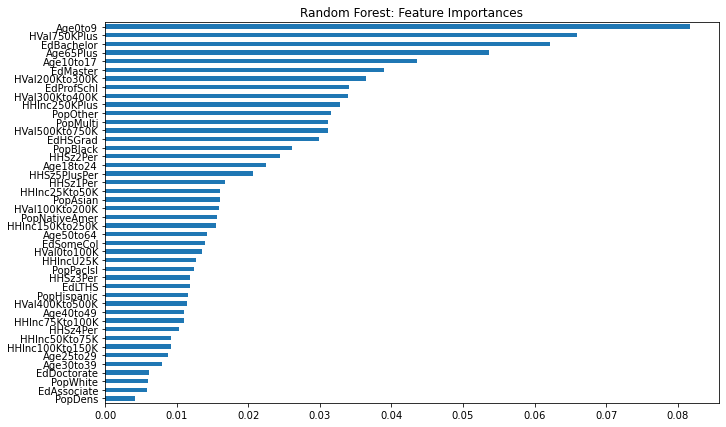

In [20]:
# Plot Feature Importance: Random Forest
# Score
random_forest_model = RandomForestClassifier().fit(X_train_transformed, y_train)
print(f'Random Forest Score in Validation Data: {random_forest_model.score(X_test_transformed, y_test).round(2)}')
# Feature Importances
feature_imp_rf = pd.Series(random_forest_model.feature_importances_, index=store_demographic_columns).sort_values()
print('Top 3 features:', list(feature_imp_rf[-3:].index)[::-1])
# Plot
feature_imp_rf.plot(kind='barh', title='Random Forest: Feature Importances')

Gradient Boosting Score in Validation Data: 0.88
Top 3 features: ['Age0to9', 'HVal750KPlus', 'EdMaster']


<AxesSubplot:title={'center':'Gradient Boosting: Feature Importances'}>

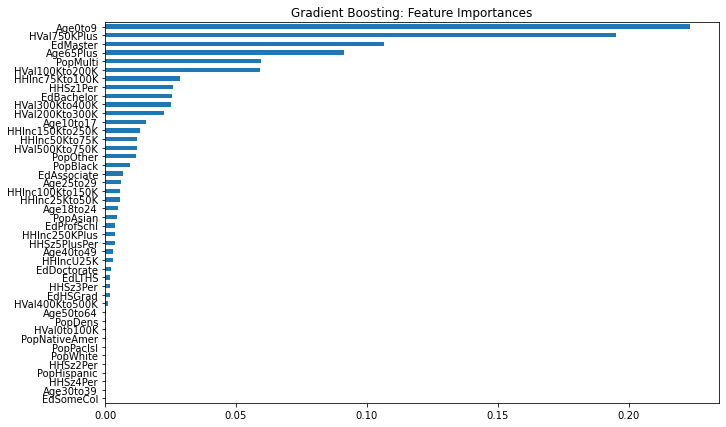

In [21]:
# Plot Feature Importance: Gradient Boosting
gradient_boosting_model = GradientBoostingClassifier().fit(X_train_transformed, y_train)
print(f'Gradient Boosting Score in Validation Data: {gradient_boosting_model.score(X_test_transformed, y_test).round(2)}')
# Feature Importances
feature_imp_gb = pd.Series(gradient_boosting_model.feature_importances_, index=store_demographic_columns).sort_values()
print('Top 3 features:', list(feature_imp_gb[-3:].index)[::-1])
# Plot
feature_imp_gb.plot(kind='barh', title='Gradient Boosting: Feature Importances')

In [22]:
# Function: To predict New Store Segment
# Input Data
new_data = store_demographic_with_info_data_new
transformed_data = column_transformer.transform(new_data)

def predict_new_store_segment(model, new_store_data=new_data, transformered_data=transformed_data):
    pred = model.predict(transformed_data)
    temp_df = new_store_data.assign(Segment = pred)
    
    return temp_df

In [23]:
# Predict Segment for New Store
segment_result_dt = predict_new_store_segment(decision_tree_model)
segment_result_rf = predict_new_store_segment(random_forest_model)
segment_result_gb = predict_new_store_segment(gradient_boosting_model)

In [24]:
# merge the result for visualazation
columns_merge = ['Store', 'Segment']
temp_merge_df = segment_result_dt[['Store', 'Type', 'Segment']].merge(segment_result_rf[columns_merge], on='Store', suffixes=('_Tree', '_Forest'))
temp_merge_df.merge(segment_result_gb[columns_merge], on='Store').rename(columns={'Segment': 'Segment_Boost'})


,Store,Type,Segment_Tree,Segment_Forest,Segment_Boost
0,S0086,New,1,1,1
1,S0087,New,2,0,0
2,S0088,New,0,1,1
3,S0089,New,0,0,0
4,S0090,New,0,0,0
5,S0091,New,2,2,2
6,S0092,New,0,0,0
7,S0093,New,2,2,2
8,S0094,New,0,0,0
9,S0095,New,2,0,0


In [25]:
columns_store_form_report = ['Store', 'Segment']
print('\nThe Segment for New Stores')
segment_result_gb[columns_store_form_report]


The Segment for New Stores


,Store,Segment
85,S0086,1
86,S0087,0
87,S0088,1
88,S0089,0
89,S0090,0
90,S0091,2
91,S0092,0
92,S0093,2
93,S0094,0
94,S0095,0


## Task 3: Forecasting
Fresh produce has a short life span, and due to increasing costs, the company wants to have an accurate monthly sales forecast.

You’ve been asked to prepare a monthly forecast for produce sales for the full year of 2016 for both existing and new stores.

Note: Use a 6 month holdout sample for the TS Compare tool (this is because we do not have that much data so using a 12 month holdout would remove too much of the data)

## Task 3 Submission
1. What type of ETS or ARIMA model did you use for each forecast? Use ETS(a,m,n) or ARIMA(ar, i, ma) notation. How did you come to that decision?


2. Please provide a table of your forecasts for existing and new stores. Also, provide visualization of your forecasts that includes historical data, existing stores forecasts, and new stores forecasts.


In [26]:
# Store ans segement pairs
# Variables to work with
columns_store_segment = ['Store', 'Segment']
# existing stores
existing_store_segment = filtered_stores_sales_2015_data[columns_store_segment]
# new stores
new_store_segement = segment_result_gb[columns_store_segment]
# Join Store Sales with Segment
stores_sales_with_segment_data = stores_sales_data.merge(existing_store_segment, on='Store')
stores_sales_with_segment_data.head(3)


,Store,Day,Month,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise,Segment
0,S0001,1,3,2012,23401.06,5567.90,3930.28,5223.61,4542.28,238.58,2608.78,1651.77,4304.79,1
1,S0001,2,3,2012,32442.93,8009.52,4712.31,6174.72,9503.45,245.29,2692.72,2688.89,4467.51,1
2,S0001,3,3,2012,40433.61,9759.20,5969.03,8010.67,12793.92,282.12,3493.85,2929.85,5721.60,1


In [27]:
# Aggregate Monthly Produce sales for existing store forecast
# existing_store_monthly_sales_data 
tmp_df= stores_sales_with_segment_data.groupby(['Year', 'Month'], as_index=False)['Produce'].agg({'Monthly_Sales': 'sum'})
# convert Year and Month columns to datetimeindex
tmp_date = tmp_df['Year'].astype(str) + '-' + tmp_df['Month'].astype(str)
tmp_df = tmp_df.assign(Date = pd.to_datetime(tmp_date))
existing_store_monthly_sales_data = tmp_df.set_index('Date', drop=True)['Monthly_Sales']
existing_store_monthly_sales_data.index.freq ='MS'
print('\nMonthly Produce Sales Data for Existing Stores')
existing_store_monthly_sales_data.head(3)


Monthly Produce Sales Data for Existing Stores


Date
2012-03-01    25151525.84
2012-04-01    24406048.39
2012-05-01    28249539.01
Freq: MS, Name: Monthly_Sales, dtype: float64

In [28]:
# Aggregate Monthly Produce sales for new store forecast 
tmp_df = stores_sales_with_segment_data.groupby(['Store','Year', 'Month', 'Segment'], as_index=False)['Produce'].agg({'Monthly_Sales': 'sum'})
tmp_df = tmp_df.groupby(['Year', 'Month', 'Segment'], as_index=False)['Monthly_Sales'].agg({'Avg_Monthly_Sales': 'mean'})
# convert Year and Month columns to datetimeindex
tmp_date = tmp_df['Year'].astype(str) + '-' + tmp_df['Month'].astype(str)
segment_store_monthly_sales_data = tmp_df.assign(Date = pd.to_datetime(tmp_date))
# Sales per Segment
# Segment 0
segment_0_store_monthly_sales_data = segment_store_monthly_sales_data.query('Segment == 0').set_index('Date', drop=True)['Avg_Monthly_Sales']
segment_0_store_monthly_sales_data.index.freq ='MS'
print('\nMonthly Produce Sales Data for segment 0 Stores')
print(segment_0_store_monthly_sales_data.head(2))
# Segment 1
segment_1_store_monthly_sales_data = segment_store_monthly_sales_data.query('Segment == 1').set_index('Date', drop=True)['Avg_Monthly_Sales']
segment_1_store_monthly_sales_data.index.freq ='MS'
print('\nMonthly Produce Sales Data for segment 1 Stores')
print(segment_1_store_monthly_sales_data.head(2))
# Segment 2
segment_2_store_monthly_sales_data = segment_store_monthly_sales_data.query('Segment == 2').set_index('Date', drop=True)['Avg_Monthly_Sales']
segment_2_store_monthly_sales_data.index.freq ='MS'
print('\nMonthly Produce Sales Data for segment 2 Stores')
print(segment_2_store_monthly_sales_data.head(2))


Monthly Produce Sales Data for segment 0 Stores
Date
2012-03-01    311095.922000
2012-04-01    307605.959667
Freq: MS, Name: Avg_Monthly_Sales, dtype: float64

Monthly Produce Sales Data for segment 1 Stores
Date
2012-03-01    303548.068710
2012-04-01    288577.200645
Freq: MS, Name: Avg_Monthly_Sales, dtype: float64

Monthly Produce Sales Data for segment 2 Stores
Date
2012-03-01    356036.558333
2012-04-01    346220.910000
Freq: MS, Name: Avg_Monthly_Sales, dtype: float64


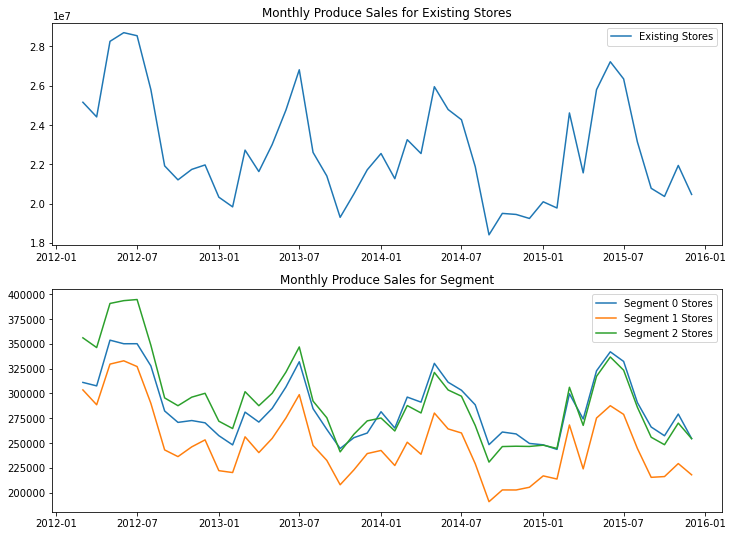

In [29]:
# Plot Aggregated Monthly Produce Sales
fig, axs = plt.subplots(2, 1, figsize=(12, 9))
axs[0].plot(existing_store_monthly_sales_data, label='Existing Stores')
axs[0].set_title('Monthly Produce Sales for Existing Stores')
axs[0].legend()

axs[1].plot(segment_0_store_monthly_sales_data, label='Segment 0 Stores')
axs[1].plot(segment_1_store_monthly_sales_data, label='Segment 1 Stores')
axs[1].plot(segment_2_store_monthly_sales_data, label='Segment 2 Stores')
axs[1].set_title('Monthly Produce Sales for Segment')
axs[1].legend()

### Monthly Produce Sales and Segment Sales follow similar patten  
Let find best model for Mothly sales then use it to train for segment sales

In [30]:
# Time Series Train Test Data
def time_series_train_test_split(df_with_date_index_data, holdout_size=6):
    train = df_with_date_index_data.iloc[:-holdout_size]
    test = df_with_date_index_data.iloc[-holdout_size:]
    return train, test

In [31]:
# Grid Search ETS Model
# Search Parameters: error, trend, damped_trend, seasonal, seasonal_periods

# helper: Format ETS to return single capital letter
def helper_ets_format(value):
    if not value:
        return 'N'
    return value[0].upper()

# intial values for Error, Trend and Seasonal
e = ['add', 'mul']
t = ['add', 'mul']
s = ['add', 'mul', None]

def ets_grid_search(train, test, errors=e, trends=t, is_damped=[True, False], seasonals=s):
    tmp_result = []
    for error in errors:
        for damped in is_damped:
            if not damped:
                trends = ['add', 'mul', None]
            for trend in trends:
                for seasonal in seasonals:
                    ets_model = ETSModel(train, error=error, trend=trend, damped_trend=damped, seasonal=seasonal, seasonal_periods=12)
                    ets_model_fit = ets_model.fit(disp=0)
                    rmse_result = rmse(test, ets_model_fit.forecast(6)).round()
                    ets_value = f'ETS{helper_ets_format(error), helper_ets_format(trend), helper_ets_format(seasonal)}'
                    tmp_parameters = [ets_value, damped, rmse_result]
                    tmp_result.append(tmp_parameters)
            trends = ['add', 'mul']
    tmp_df = pd.DataFrame(tmp_result, columns=['Model', 'Damped_Trend', 'RMSE'])
    tmp_df = tmp_df.sort_values(by='RMSE')
    return tmp_df.assign(RMSE = lambda x: x.RMSE.map('{:,}'.format))

In [32]:
# Run ETS Grid Search
train, test = time_series_train_test_split(existing_store_monthly_sales_data)
# est_gridsearch_result = ets_grid_search(train, test)

In [33]:
# Best ETS Model
print('ETS Top 5 Best Model')
# est_gridsearch_result.head()

ETS Top 5 Best Model


In [50]:
# Grid Search ARIMA Model
# Search Parameters: order, trend
possible_p = range(1,13)
possible_q = range(13)
possible_d = range(3) #use pmdarima ndiff function to finds max d value for adf, kpss and pp test we get 2
possible_trend = ['n', 'c', 't', 'ct']

def arima_grid_search(train, test, ps=possible_p, ds=possible_d, qs=possible_q, trends=possible_trend):
    tmp_result = []
    for d in ds:
        for p in ps:
            for q in qs:
                for trend in trends:
                    try:
                        model = ARIMA(train, order=(p,d,q), trend=trend)
                        model_fit = model.fit()
                        rmse_result = rmse(test, model_fit.forecast(6)).round()
                    except:
                        rmse_result = float('inf')

                    arima_value = f'ARIMA{p,d,q}'
                    tmp_parameters = [arima_value, trend, rmse_result]
                    tmp_result.append(tmp_parameters)

    tmp_df = pd.DataFrame(tmp_result, columns=['Model', 'Trend', 'RMSE'])
    tmp_df = tmp_df.sort_values(by='RMSE')
    return tmp_df.assign(RMSE = lambda x: x.RMSE.map('{:,}'.format))

In [51]:
# Run ARIMA Grid Search
train, test = time_series_train_test_split(existing_store_monthly_sales_data)
arima_gridsearch_result = arima_grid_search(train, test)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: Convergence

In [52]:
# Best ARIMA Model
print('ARIMA Top 5 Best Model')
arima_gridsearch_result.head()

ARIMA Top 5 Best Model


,Model,Trend,RMSE
549,"ARIMA(11, 0, 7)",c,"679,310.0"
71,"ARIMA(2, 0, 4)",ct,"689,601.0"
19,"ARIMA(1, 0, 4)",ct,"708,207.0"
341,"ARIMA(7, 0, 7)",c,"753,182.0"
541,"ARIMA(11, 0, 5)",c,"800,716.0"


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


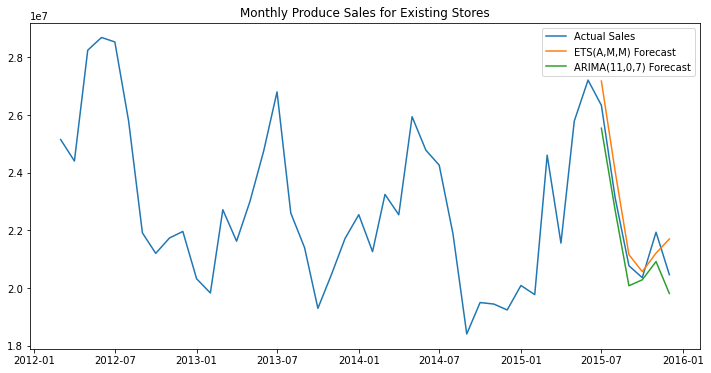

In [60]:
# Model Selection:
# ETS Model: ETS(A,M,M) with damped trend
ets_model = ETSModel(train, error='add', trend='mul', damped_trend=True, seasonal='mul', seasonal_periods=12)
ets_model_fit = ets_model.fit(disp=0)
ets_forecast = ets_model_fit.forecast(6).round(2)

# ARIMA Model: ARIMA(0,0,2) with constant trend 'ct'
arima_model = ARIMA(train, order=(11,0,7), trend='c')
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(6).round(2)

# Plot Models Holdout Forecast
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
# Plot Actual Sales
axs.plot(existing_store_monthly_sales_data, label='Actual Sales')
# Plot ETS forecast Sales
axs.plot(ets_forecast, label='ETS(A,M,M) Forecast')
# Plot ARIMA forecast Sales
axs.plot(arima_forecast, label='ARIMA(11,0,7) Forecast')
# add title and legend
axs.set_title('Monthly Produce Sales for Existing Stores')
axs.legend()

In [62]:
# Forecast 2016 Sales for Existing Stores
# Train the model with all data
existing_stores_forecast = ARIMA(existing_store_monthly_sales_data, order=(11,0,7), trend='c').fit().forecast(12).round()
existing_stores_forecast

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2016-01-01    22354701.0
2016-02-01    21195450.0
2016-03-01    22934136.0
2016-04-01    24188368.0
2016-05-01    25788549.0
2016-06-01    26647209.0
2016-07-01    25764732.0
2016-08-01    22507490.0
2016-09-01    21831761.0
2016-10-01    19556509.0
2016-11-01    21270663.0
2016-12-01    20883969.0
Freq: MS, Name: predicted_mean, dtype: float64

In [63]:
# Forecast 2016 Sales for New Stores
# Train the model with all data in segment
segment_0_stores_forecast = ARIMA(segment_0_store_monthly_sales_data, order=(11,0,7), trend='c').fit().forecast(12).round()
segment_1_stores_forecast = ARIMA(segment_1_store_monthly_sales_data, order=(11,0,7), trend='c').fit().forecast(12).round()
segment_2_stores_forecast = ARIMA(segment_2_store_monthly_sales_data, order=(11,0,7), trend='c').fit().forecast(12).round()
# commbine segments
segment_stores_forecast = pd.concat([segment_0_stores_forecast, segment_1_stores_forecast, segment_2_stores_forecast], axis=1)
segment_stores_forecast.columns = ['Segment_0', 'Segment_1', 'Segment_2']
# Count the segment in best cluster selected
best_cluster = segment_result_gb
segment_counts = best_cluster['Segment'].value_counts()
# add total sales per month
segment_stores_forecast = segment_stores_forecast.assign(Monthly_Sales = lambda x: x.Segment_0*segment_counts[0]+x.Segment_1*segment_counts[1]+x.Segment_2*segment_counts[2])
segment_stores_forecast['Monthly_Sales']

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2016-01-01    2669384.0
2016-02-01    2504466.0
2016-03-01    2795400.0
2016-04-01    2879334.0
2016-05-01    3121174.0
2016-06-01    3210338.0
2016-07-01    3091232.0
2016-08-01    2810498.0
2016-09-01    2682490.0
2016-10-01    2483706.0
2016-11-01    2646286.0
2016-12-01    2512536.0
Freq: MS, Name: Monthly_Sales, dtype: float64

In [85]:
# combine forecasted data
forecasted_result = pd.concat([existing_stores_forecast, segment_stores_forecast['Monthly_Sales']], axis=1)
forecasted_result.columns = ['Existing_Stores_Forecast', 'New_Stores_Forecast']
forecasted_result.index = forecasted_result.index.to_period('M')
# total mothly forecast sales
forecasted_result = forecasted_result.assign(Total_Stores_Forecast = lambda x: x.Existing_Stores_Forecast + x.New_Stores_Forecast)
forecasted_result

,Existing_Stores_Forecast,New_Stores_Forecast,Total_Stores_Forecast
2016-01,22354701.0,2669384.0,25024085.0
2016-02,21195450.0,2504466.0,23699916.0
2016-03,22934136.0,2795400.0,25729536.0
2016-04,24188368.0,2879334.0,27067702.0
2016-05,25788549.0,3121174.0,28909723.0
2016-06,26647209.0,3210338.0,29857547.0
2016-07,25764732.0,3091232.0,28855964.0
2016-08,22507490.0,2810498.0,25317988.0
2016-09,21831761.0,2682490.0,24514251.0
2016-10,19556509.0,2483706.0,22040215.0


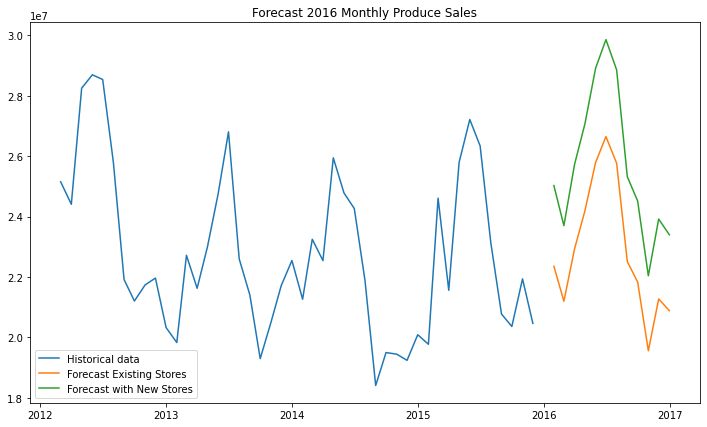

In [84]:
# Plot Models 2016 Forecast
fig, axs = plt.subplots(1, 1, figsize=(12, 7))
axs.plot(existing_store_monthly_sales_data, label='Historical data')
axs.plot(forecasted_result['Existing_Stores_Forecast'], label='Forecast Existing Stores')
axs.plot(forecasted_result['Total_Stores_Forecast'], label='Forecast with New Stores')
axs.set_title('Forecast 2016 Monthly Produce Sales')
axs.legend()